In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [50]:
kharpov = True

In [51]:
if kharpov:
    true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'zeta': .91,
               'scale': .1,
               'delta': 1.11,
               'rho': .6,
              }
else:
     true_params = {'equity_price': 0.47, 
               'vol_price': -.13,
               'zeta': .91,
               'scale': 2.50,
               'delta': 0.29,
               'rho': .83,
              }
    
time_dim = 1000
sim_dim = 1000
innov_dim = 1000

## Setup the linking functions.

In [52]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       zeta=true_params['zeta'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], zeta=true_params['zeta'], 
                  theta=true_params['equity_price'])})

In [53]:
true_params['zeta']

0.91

In [56]:
zeta_val = .999999
true_params['equity_price']= vl.compute_theta(psi=total_true_params['psi'], scale=true_params['scale'],
                                                             rho=true_params['rho'], zeta=zeta_val)
true_params['zeta'] = zeta_val
print("Theta is {:.2f}".format(true_params['equity_price']))

Theta is 1.25


In [58]:
vl.sym.init_printing()

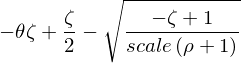

In [100]:
vl.psi_sym

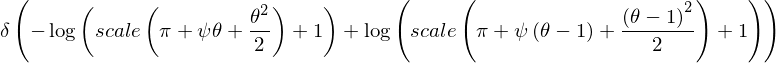

In [99]:
vl.gamma_sym.replace(vl.zeta,1)

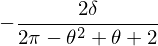

In [97]:
vl.gamma_sym.diff(vl.psi).replace(vl.psi, vl.psi_sym).replace(vl.scale,1).replace(vl.zeta,1).simplify()

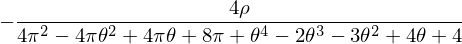

In [85]:
vl.beta_sym.diff(vl.psi).replace(vl.psi, vl.psi_sym).replace(vl.zeta,1).replace(vl.scale,1).simplify()

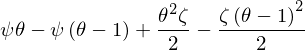

In [78]:
(vl.alpha.replace(vl.x, vl.theta) - vl.alpha.replace(vl.x, vl.theta-1))

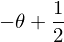

In [70]:
vl.psi_sym.replace(vl.zeta, 1)

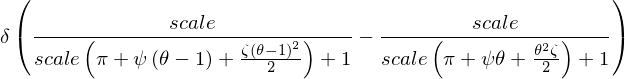

In [64]:
vl.gamma_sym.diff(vl.pi).replace(zeta,1)

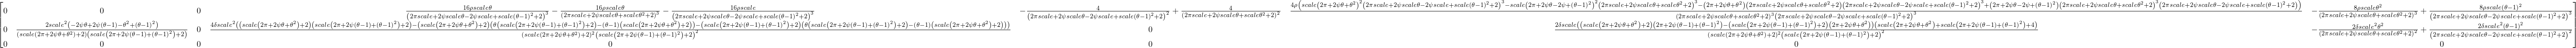

In [62]:
vl.link_func_grad_sym.diff(vl.pi).replace(vl.zeta,1).simplify()

In [57]:
vl.compute_link_price_grad(pi=-7, theta=1.17, **omega)

array([[0.287, 4.854],
       [0.009, 0.318],
       [0.   , 0.   ]])

## We start by examining the distributions of simulated data

In [9]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [10]:
data.head()

,vol,rtn
2000-01-01,0.190222,-0.572424
2000-01-02,0.317920,-0.312677
2000-01-03,0.374618,-0.425581
2000-01-04,0.662881,0.345395
2000-01-05,0.303730,1.085262


In [11]:
rho = true_params['rho']
scale = true_params['scale']
vol_price = true_params['vol_price']
equity_price = true_params['equity_price']
delta = true_params['delta']
zeta = true_params['zeta']

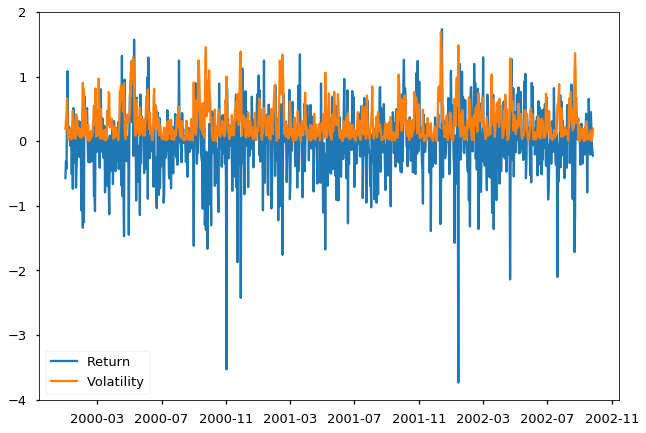

In [12]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()

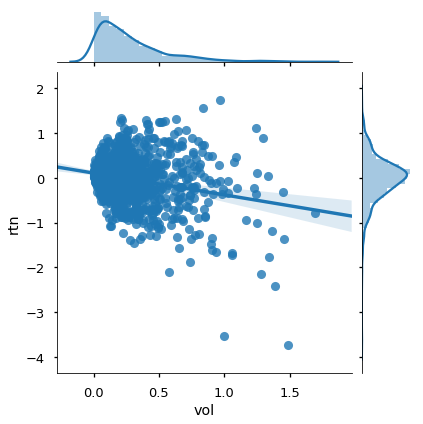

In [13]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [14]:
data.describe()

,vol,rtn
count,1000.000000,1000.000000
mean,0.282631,-0.030077
std,0.265873,0.536807
min,0.000063,-3.736700
25%,0.088051,-0.291441
50%,0.204484,0.019445
75%,0.386679,0.255513
max,1.695054,1.733552


## I now estimate all of the parameters

In [15]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [16]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.estimate_params_strong_id, data_arr),
                                      total=len(data_arr)))

In [17]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean   / np.sqrt(np.diag(cov) / data.vol.size)

In [18]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

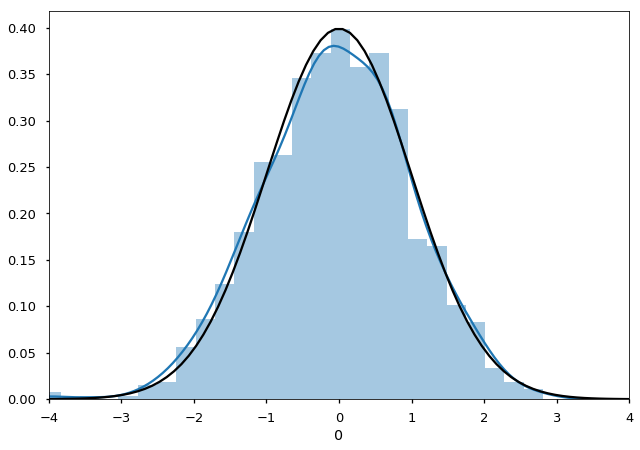

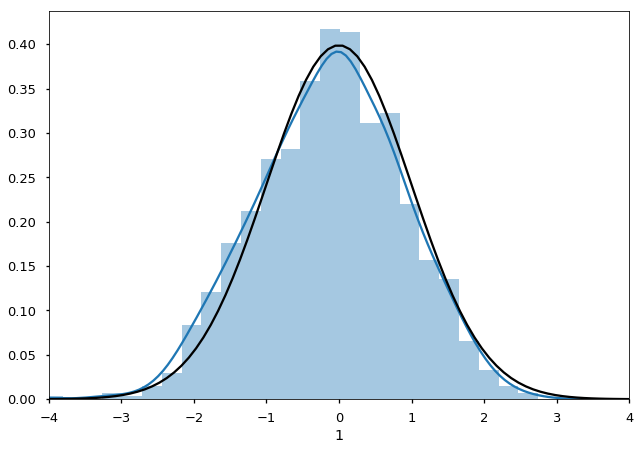

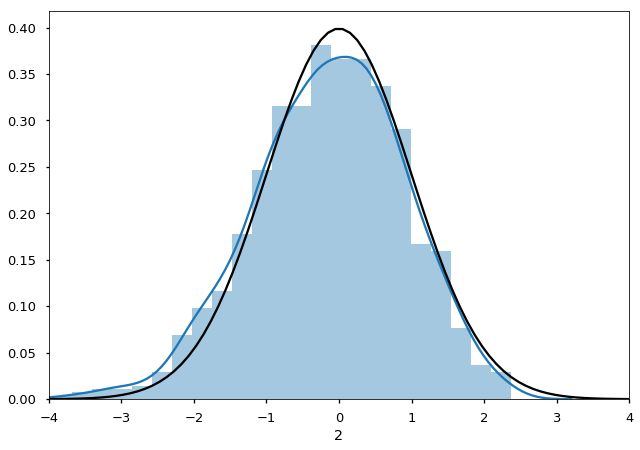

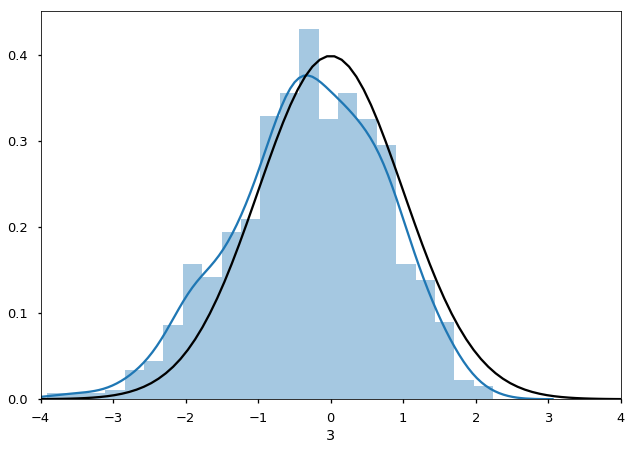

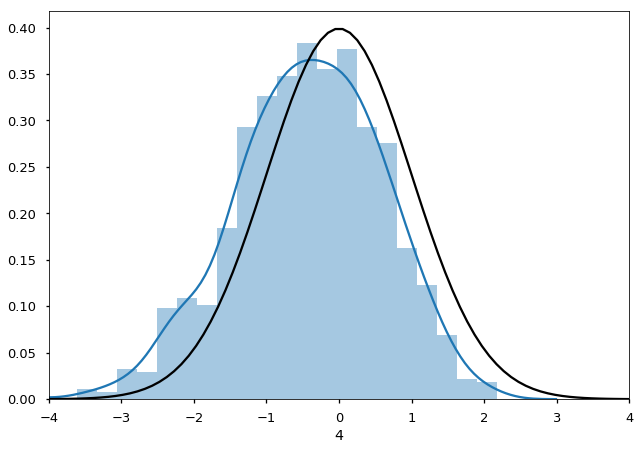

In [19]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

Text(0.5,0,'delta')

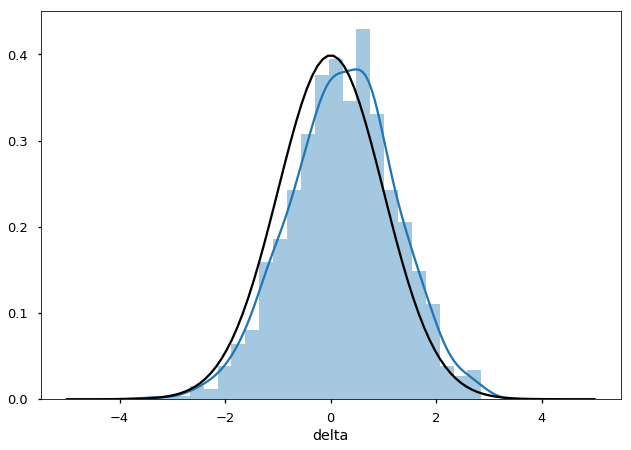

In [20]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

Text(0.5,0,'scale')

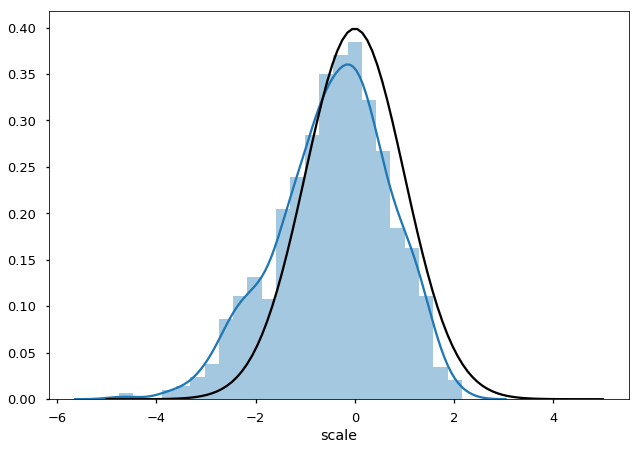

In [21]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')


Text(0.5,0,'rho')

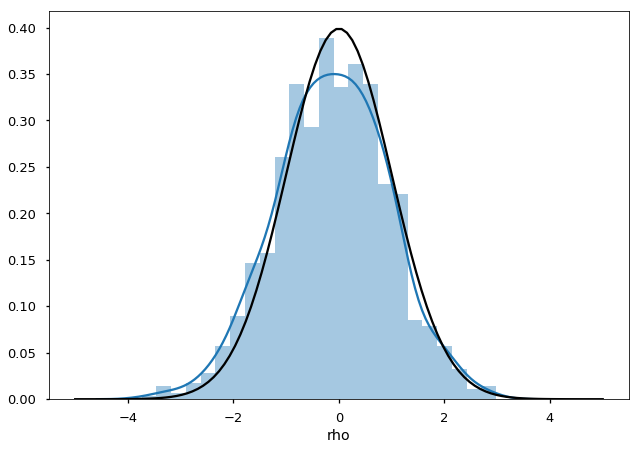

In [22]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

(-10, 10)

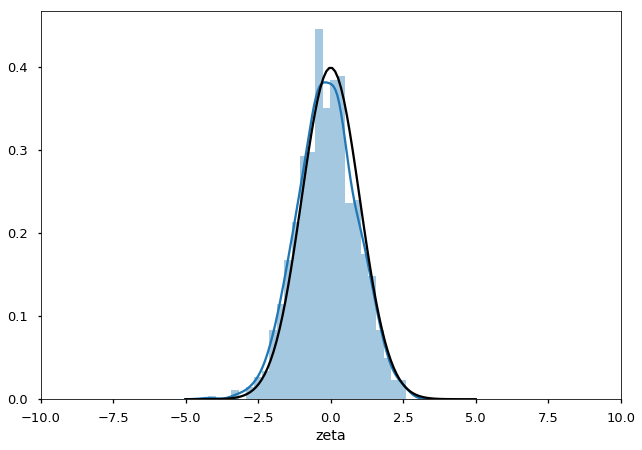

In [23]:
zeta_fig, zeta_ax = mpl.pyplot.subplots()
sns.distplot([(est['zeta'] - true_params['zeta']) / np.sqrt(cov.loc['zeta', 'zeta'])
              for est, cov in est_arr], ax=zeta_ax)
zeta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
zeta_ax.set_xlabel('zeta')
zeta_ax.set_xlim([-10,10])

Text(0.5,0,'equity price')

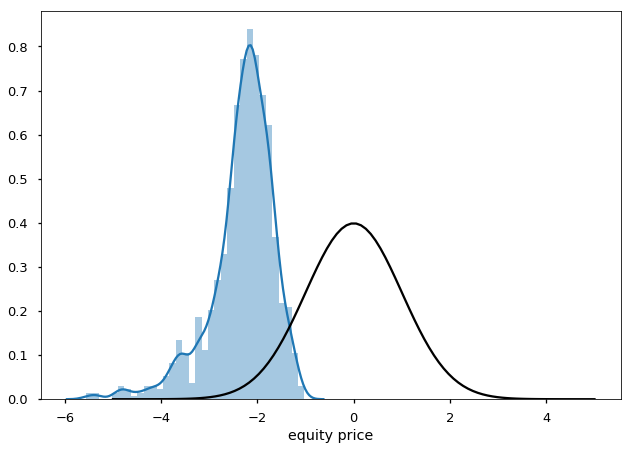

In [24]:
equity_price_fix, equity_price_ax = mpl.pyplot.subplots()
rescaled_data = pd.Series([((est['equity_price'] - true_params['equity_price']) / 
              np.sqrt(cov.loc['equity_price', 'equity_price'])) for est, cov in est_arr]).dropna()
sns.distplot(rescaled_data , ax=equity_price_ax)
equity_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
equity_price_ax.set_xlabel('equity price')

Text(0.5,0,'vol_price')

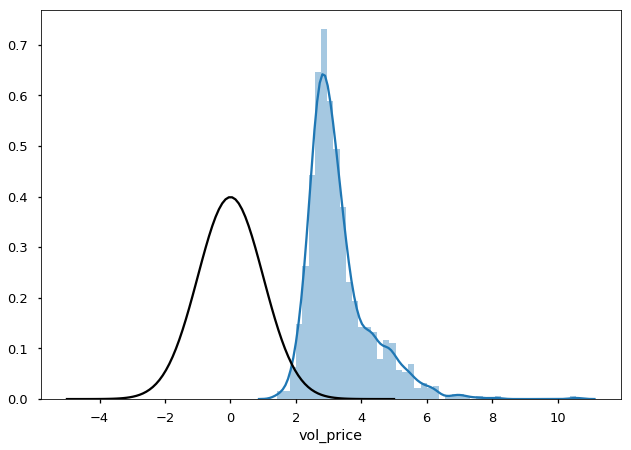

In [25]:
vol_price_fix, vol_price_ax = mpl.pyplot.subplots()
rescaled_data = pd.Series([((est['vol_price'] - true_params['vol_price']) / 
              np.sqrt(cov.loc['vol_price', 'vol_price'])) for est, cov in est_arr]).dropna()
sns.distplot(rescaled_data , ax=vol_price_ax)
vol_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
vol_price_ax.set_xlabel('vol_price')

In [35]:
param_est, param_cov = est_arr[0]
names = ['equity_price', 'vol_price']
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
true_prices = true_params['equity_price'], true_params['vol_price']

In [40]:
true_params['equity_price']

1.1716146731689594

In [44]:
omega

{'gamma': 0.01914272939152235,
 'beta': 0.600217627723536,
 'psi': -0.7816945954429643,
 'zeta': 1.0114352370883086,
 'delta': 1.2130381080282802,
 'rho': 0.5867845127038513,
 'scale': 0.09106610038927615}

In [45]:
vl.compute_link_grad(pi=-3, theta=1.17, **omega)

array([[ 1.   ,  0.   ,  0.   ,  1.183, -0.221, -1.158,  0.79 ],
       [ 0.   , -0.014,  1.   ,  0.157,  0.   , -0.268,  0.105],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.447]])

array([[0.287, 4.854],
       [0.009, 0.318],
       [0.   , 0.   ]])

In [42]:
vl._qlr_in([1.17, -4], omega, omega_cov, inv_weight=True)

22.785513815289264

# I now compute the robust conditional QLR statistic 

In [26]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05,
                                        robust_quantile=False)

In [30]:
returnval.mean()

qlr_stat    2.002512
standard    0.059000
dtype: float64

In [31]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}.json'.format(innov_dim, true_params['zeta'])
else:
    filename = '../results/reject_prop_{}_{}.json'.format(innov_dim, true_params['zeta'])
    
returnval.to_json(filename)

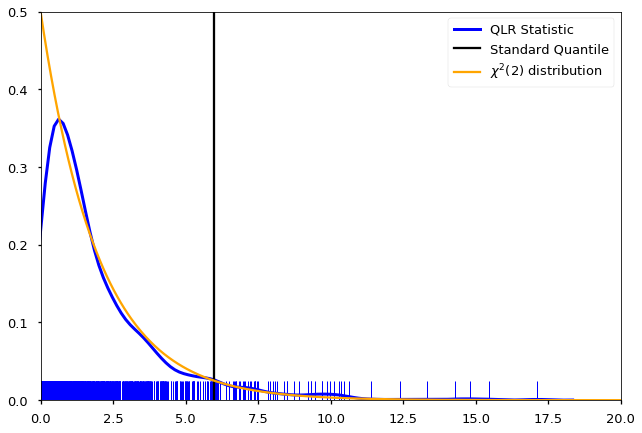

In [32]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.robust_qlr_qauntile, rug=True, kde_kws={"color": "orange", "lw": 3},
                 hist_kws={"color":'orange'}, ax=ax4, bins=np.arange(0, returnval.robust_qlr_qauntile.max(),.5),
                label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, rug=True, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3},
            rug_kws={'color':'blue'}, label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=2), color='black', label='Standard Quantile')
xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.pdf(x, df=2) for x in xvals], color='orange', label='$\chi^2(2)$ distribution')
ax4.set_xlim([0,20])
ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['zeta']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)